# **Imports**

In [29]:
# Common
import os
import cv2 as cv
from keras.metrics import MeanIoU
from tqdm import tqdm

# data 
import numpy as np 
from keras.preprocessing.image import load_img, img_to_array

# viz
import matplotlib.pyplot as plt

# Model
import keras 
import tensorflow as tf
from keras.layers import Conv2D, MaxPool2D, Dropout, BatchNormalization, Input, Conv2DTranspose, concatenate, GlobalAveragePooling2D, Dense
from keras import Sequential 
from keras.callbacks import EarlyStopping, ModelCheckpoint

# **Data**

In [30]:
def show_image(image, cmap=None, title=None):
  plt.imshow(image, cmap=cmap)
  if title is not None: plt.title(title)
  plt.axis('off')


In [31]:
images = []
mask = []

image_path = '../input/satellite-images-of-water-bodies/Water Bodies Dataset/Images/'
mask_path = '../input/satellite-images-of-water-bodies/Water Bodies Dataset/Masks/'

image_names = sorted(next(os.walk(image_path))[-1])
mask_names = sorted(next(os.walk(mask_path))[-1])

if image_names == mask_names:
  print('Image and Mask are corretly Placed!!')

Image and Mask are corretly Placed!!


In [32]:
SIZE = 128
images = np.zeros(shape=(len(image_names),SIZE, SIZE, 3))
masks = np.zeros(shape=(len(image_names),SIZE, SIZE, 1))

for id in tqdm(range(len(image_names)), desc="Images"):
  path = image_path + image_names[id]
  img = img_to_array(load_img(path)).astype('float')/255.
  img = cv.resize(img, (SIZE,SIZE), cv.INTER_AREA)
  images[id] = img

for id in tqdm(range(len(mask_names)), desc="Mask"):
  path = mask_path + mask_names[id]
  mask = img_to_array(load_img(path)).astype('float')/255.
  mask = cv.resize(mask, (SIZE,SIZE), cv.INTER_AREA)
  masks[id] = mask[:,:,:1]

Mask: 100%|██████████| 2841/2841 [00:39<00:00, 71.13it/s] 


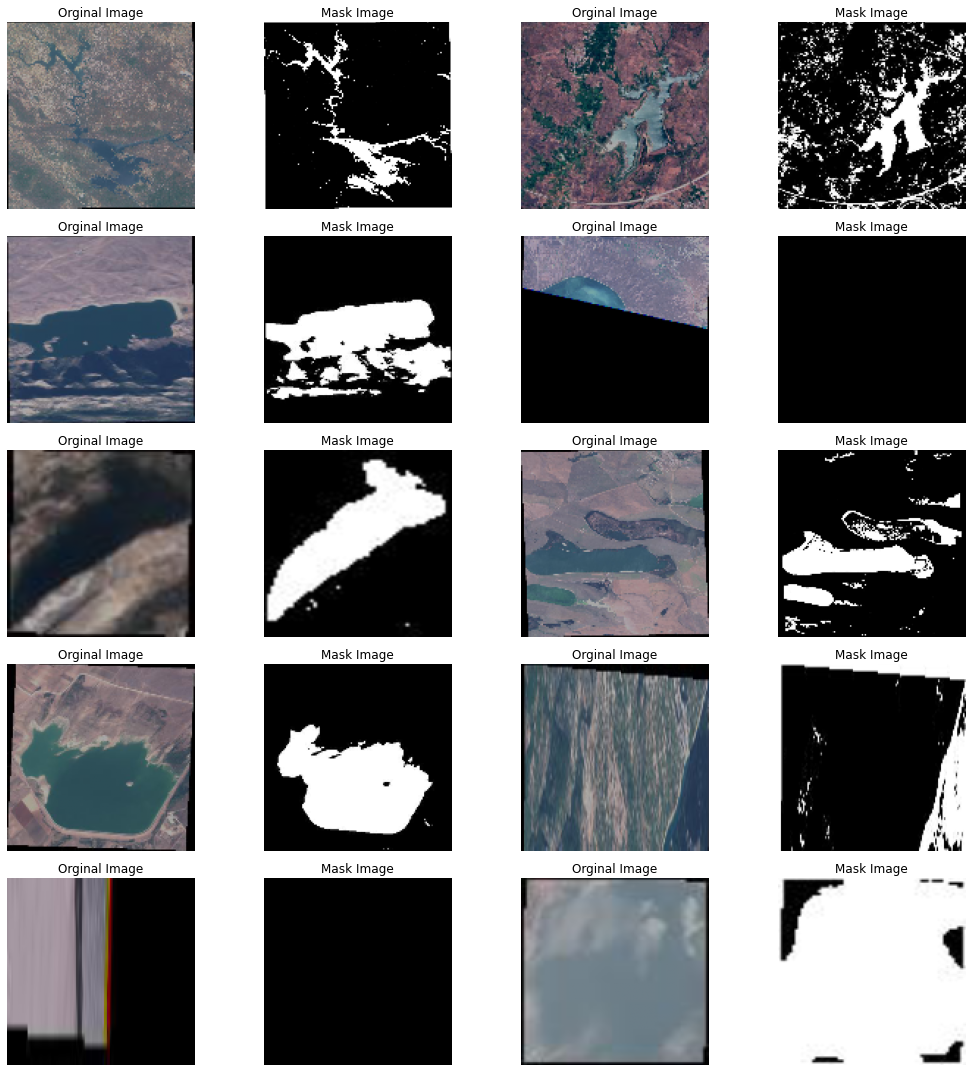

In [33]:
plt.figure(figsize=(15,15))
for i in range(1,21):
  plt.subplot(5,4,i)

  if i%2!=0:
    id = np.random.randint(len(images))
    show_image(images[id], title="Orginal Image")
  elif i%2==0:
    show_image(masks[id].reshape(128,128), title="Mask Image", cmap='gray')

plt.tight_layout()
plt.show()

# **U-Net**

In [34]:
X, y = images[:int(len(images)*0.9)], masks[:int(len(images)*0.9)]
test_X, test_y = images[int(len(images)*0.9):], masks[int(len(images)*0.9):]

In [35]:
# Contraction 
class EncoderBlock(keras.layers.Layer):
  
  def __init__(self, filters, rate=None, pooling=True):
    super(EncoderBlock,self).__init__()
    self.filters = filters
    self.rate = rate
    self.pooling = pooling
    self.conv1 = Conv2D(self.filters,kernel_size=3,strides=1,padding='same',activation='relu',kernel_initializer='he_normal')
    self.conv2 = Conv2D(self.filters,kernel_size=3,strides=1,padding='same',activation='relu',kernel_initializer='he_normal')
    if self.pooling: self.pool = MaxPool2D(pool_size=(2,2))
    if self.rate is not None: self.drop = Dropout(rate)
    
  def call(self, inputs):
    x = self.conv1(inputs)
    if self.rate is not None: x = self.drop(x)
    x = self.conv2(x)
    if self.pooling: 
      y = self.pool(x)
      return y, x
    else:
      return x
  
  def get_config(self):
    base_config = super().get_config()
    return {
        **base_config, 
        "filters":self.filters,
        "rate":self.rate,
        "pooling":self.pooling
    }

# Expansion
class DecoderBlock(keras.layers.Layer):
  
  def __init__(self, filters, rate=None, axis=-1):
    super(DecoderBlock,self).__init__()
    self.filters = filters
    self.rate = rate
    self.axis = axis
    self.convT = Conv2DTranspose(self.filters,kernel_size=3,strides=2,padding='same')
    self.conv1 = Conv2D(self.filters, kernel_size=3, activation='relu', kernel_initializer='he_normal', padding='same')
    if rate is not None: self.drop = Dropout(self.rate)
    self.conv2 = Conv2D(self.filters, kernel_size=3, activation='relu', kernel_initializer='he_normal', padding='same')
    
  def call(self, inputs):
    X, short_X = inputs
    ct = self.convT(X)
    c_ = concatenate([ct, short_X], axis=self.axis)
    x = self.conv1(c_)
    if self.rate is not None: x = self.drop(x)
    y = self.conv2(x)
    return y
  
  def get_config(self):
    base_config = super().get_config()
    return {
        **base_config, 
        "filters":self.filters,
        "rate":self.rate,
        "axis":self.axis,
    }

# Callback 
class ShowProgress(keras.callbacks.Callback):
  def __init__(self, save=False):
    self.save = save
  def on_epoch_end(self, epoch, logs=None):
    id = np.random.randint(len(images))
    real_img = images[id][np.newaxis,...]
    pred_mask = self.model.predict(real_img).reshape(128,128)
    proc_mask1 = post_process(pred_mask)
    proc_mask2 = post_process(pred_mask, threshold=0.5)
    proc_mask3 = post_process(pred_mask, threshold=0.9)
    mask = masks[id].reshape(128,128)

    plt.figure(figsize=(10,5))

    plt.subplot(1,6,1)
    show_image(real_img[0], title="Orginal Image")

    plt.subplot(1,6,2)
    show_image(pred_mask, title="Predicted Mask", cmap='gray')
    
    plt.subplot(1,6,3)
    show_image(mask, title="Orginal Mask", cmap='gray')

    plt.subplot(1,6,4)
    show_image(proc_mask1, title="Processed@0.4", cmap='gray')

    plt.subplot(1,6,5)
    show_image(proc_mask2, title="Processed@0.5", cmap='gray')

    plt.subplot(1,6,6)
    show_image(proc_mask3, title="Processed@0.9", cmap='gray')

    plt.tight_layout()
    if self.save: plt.savefig("Progress-{}.png".format(epoch+1))
    plt.show()

# Post Process
def post_process(image,threshold=0.4):
  return image>threshold


In [36]:
inputs= Input(shape=(SIZE,SIZE,3))

# Contraction 
p1, c1 = EncoderBlock(16,0.1)(inputs)
p2, c2 = EncoderBlock(32,0.1)(p1)
p3, c3 = EncoderBlock(64,0.2)(p2)
p4, c4 = EncoderBlock(128,0.2)(p3)

# Encoding Layer
c5 = EncoderBlock(256,rate=0.3,pooling=False)(p4) 

# Expansion
d1 = DecoderBlock(128,0.2)([c5,c4]) # [current_input, skip_connection]
d2 = DecoderBlock(64,0.2)([d1,c3])
d3 = DecoderBlock(32,0.1)([d2,c2])
d4 = DecoderBlock(16,0.1, axis=3)([d3,c1])

# Outputs 
outputs = Conv2D(1,1,activation='sigmoid')(d4)

unet = keras.models.Model(
    inputs=[inputs],
    outputs=[outputs],
)

In [37]:
unet.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
)

In [38]:
callbacks = [
    EarlyStopping(patience=3, restore_best_weights=True),
    ModelCheckpoint('UNet-01.h5',save_best_only=True),
    ShowProgress(save=True)
]

When I train models that actually produce images, I mostly trust my own eyes than trusting the matrics.

In [39]:
unet.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
encoder_block_15 (EncoderBlock) ((None, 64, 64, 16), 2768        input_4[0][0]                    
__________________________________________________________________________________________________
encoder_block_16 (EncoderBlock) ((None, 32, 32, 32), 13888       encoder_block_15[0][0]           
__________________________________________________________________________________________________
encoder_block_17 (EncoderBlock) ((None, 16, 16, 64), 55424       encoder_block_16[0][0]           
____________________________________________________________________________________________

Epoch 1/100
144/144 [==============================] - 6s 31ms/step - loss: 0.5407 - accuracy: 0.6007 - val_loss: 0.4763 - val_accuracy: 0.6315


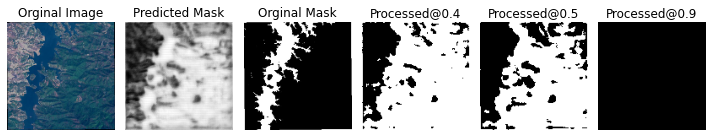

Epoch 2/100
144/144 [==============================] - 4s 27ms/step - loss: 0.4771 - accuracy: 0.6404 - val_loss: 0.4472 - val_accuracy: 0.6418


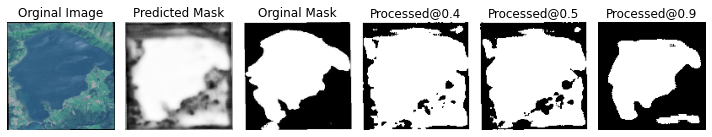

Epoch 3/100
144/144 [==============================] - 4s 28ms/step - loss: 0.4395 - accuracy: 0.6618 - val_loss: 0.3917 - val_accuracy: 0.6694


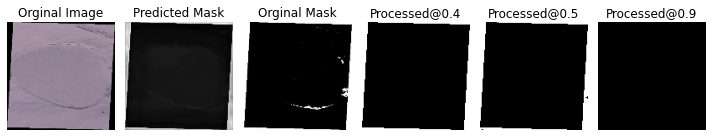

Epoch 4/100
144/144 [==============================] - 4s 28ms/step - loss: 0.4237 - accuracy: 0.6686 - val_loss: 0.4006 - val_accuracy: 0.6675


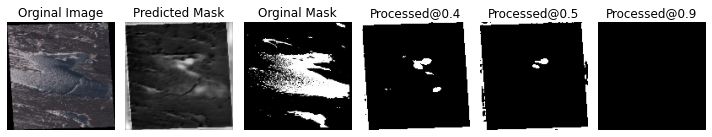

Epoch 5/100
144/144 [==============================] - 4s 29ms/step - loss: 0.3983 - accuracy: 0.6798 - val_loss: 0.3608 - val_accuracy: 0.6864


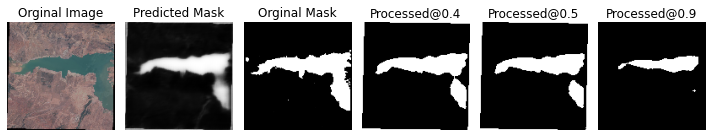

Epoch 6/100
144/144 [==============================] - 4s 28ms/step - loss: 0.3813 - accuracy: 0.6862 - val_loss: 0.3367 - val_accuracy: 0.7019


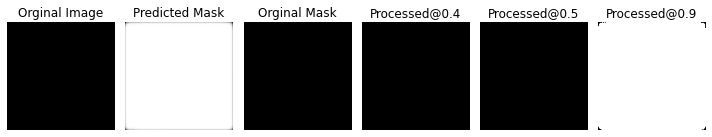

Epoch 7/100
144/144 [==============================] - 4s 27ms/step - loss: 0.3849 - accuracy: 0.6856 - val_loss: 0.3666 - val_accuracy: 0.6758


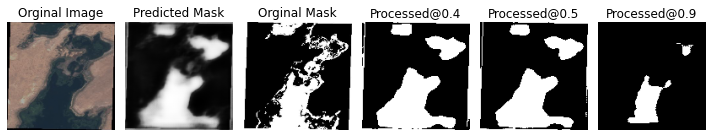

Epoch 8/100
144/144 [==============================] - 4s 27ms/step - loss: 0.3757 - accuracy: 0.6907 - val_loss: 0.3341 - val_accuracy: 0.6949


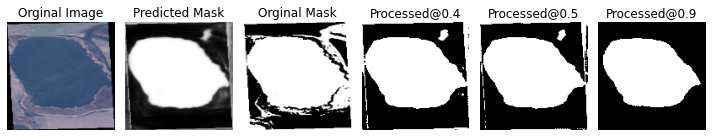

Epoch 9/100
144/144 [==============================] - 4s 27ms/step - loss: 0.3593 - accuracy: 0.6958 - val_loss: 0.2939 - val_accuracy: 0.7200


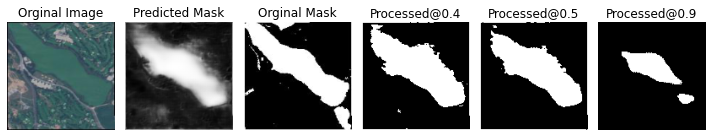

Epoch 10/100
144/144 [==============================] - 4s 28ms/step - loss: 0.3445 - accuracy: 0.7018 - val_loss: 0.2911 - val_accuracy: 0.7188


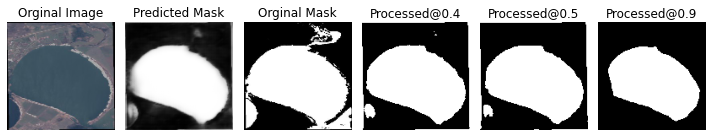

Epoch 11/100
144/144 [==============================] - 4s 27ms/step - loss: 0.3419 - accuracy: 0.7034 - val_loss: 0.2852 - val_accuracy: 0.7193


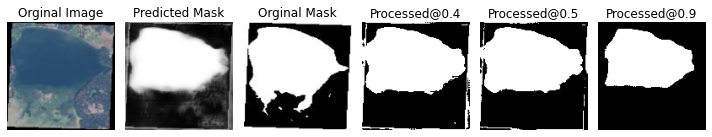

Epoch 12/100
144/144 [==============================] - 4s 28ms/step - loss: 0.3562 - accuracy: 0.6963 - val_loss: 0.2935 - val_accuracy: 0.7164


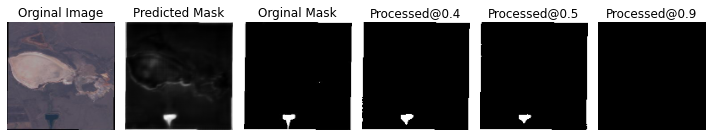

Epoch 13/100
144/144 [==============================] - 4s 27ms/step - loss: 0.3725 - accuracy: 0.6907 - val_loss: 0.3046 - val_accuracy: 0.7138


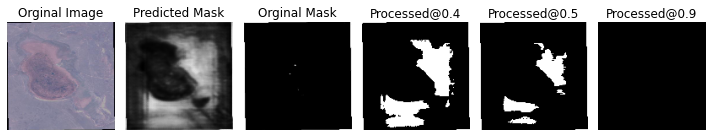

Epoch 14/100
144/144 [==============================] - 4s 28ms/step - loss: 0.4065 - accuracy: 0.6838 - val_loss: 0.4690 - val_accuracy: 0.6154


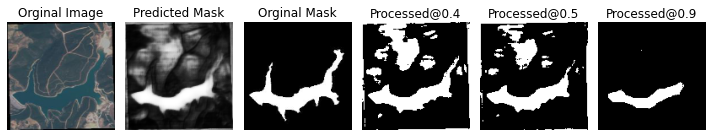

CPU times: user 1min 2s, sys: 4.89 s, total: 1min 7s
Wall time: 1min 8s


In [40]:
%%time
with tf.device("/GPU:0"):
  results = unet.fit(
      X, y,
      epochs=100,
      callbacks=callbacks,
      validation_split=0.1,
      batch_size=16
  )

* After looking at the produced images, it could be said that the model is actually able to identify the regions of water but its confused between water and forest when the color difference between them is low.

* It could also be noticed that the model is actually preserving some of these spatial features which we actually don't want in the final image. That's why I have post processed it.

* Overall, the model is great. It's actually able to identify the regions correctly. Well, not exactly up to the point, but roughly correct enough to be convincing.

# **Adaptive Threshold UNET**

In [41]:
# Callback 
class ShowProgress(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    id = np.random.randint(len(images))
    real_img = images[id][np.newaxis,...]
    pred_mask = self.model.predict(real_img).reshape(128,128)
    proc_mask1 = post_process(pred_mask, threshold=0.5)
    thresh = float(np.mean(pred_mask) + np.min(pred_mask))
    proc_mask2 = post_process(pred_mask, threshold=thresh)
    mask = masks[id].reshape(128,128)

    plt.figure(figsize=(15,6))

    plt.subplot(1,5,1)
    show_image(real_img[0], title="Orginal Image")

    plt.subplot(1,5,2)
    show_image(pred_mask, title="Predicted Mask", cmap='gray')
    
    plt.subplot(1,5,3)
    show_image(mask, title="Orginal Mask", cmap='gray')

    plt.subplot(1,5,4)
    show_image(proc_mask1, title="Processed@0.4", cmap='gray')

    plt.subplot(1,5,5)
    show_image(proc_mask2, title="Processed@{:.2}".format(thresh), cmap='gray')

    plt.tight_layout()
    plt.show()

# Post Process
def post_process(image,threshold): return image>threshold

In [42]:
inputs= Input(shape=(SIZE,SIZE,3))

# Contraction 
p1, c1 = EncoderBlock(16,0.1)(inputs)
p2, c2 = EncoderBlock(32,0.1)(p1)
p3, c3 = EncoderBlock(64,0.2)(p2)
p4, c4 = EncoderBlock(128,0.2)(p3)

# Encoding Layer
c5 = EncoderBlock(256,rate=0.3,pooling=False)(p4) 

# Expansion
d1 = DecoderBlock(128,0.2)([c5,c4]) # [current_input, skip_connection]
d2 = DecoderBlock(64,0.2)([d1,c3])
d3 = DecoderBlock(32,0.1)([d2,c2])
d4 = DecoderBlock(16,0.1, axis=3)([d3,c1])

# Outputs
outputs = Conv2D(1,1,activation='sigmoid')(d4)

unet = keras.models.Model(
    inputs=[inputs],
    outputs=[outputs],
)

In [43]:
unet.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
)

In [44]:
callbacks = [
    EarlyStopping(patience=3, restore_best_weights=True),
    ModelCheckpoint('Adaptive-UNet.h5',save_best_only=True),
    ShowProgress()
]

I saved the model with a different name even though the model doesn't learn anything new, but I thought let's keep them separated.

Epoch 1/100
72/72 [==============================] - 5s 54ms/step - loss: 0.5711 - accuracy: 0.5758 - val_loss: 0.5111 - val_accuracy: 0.5920


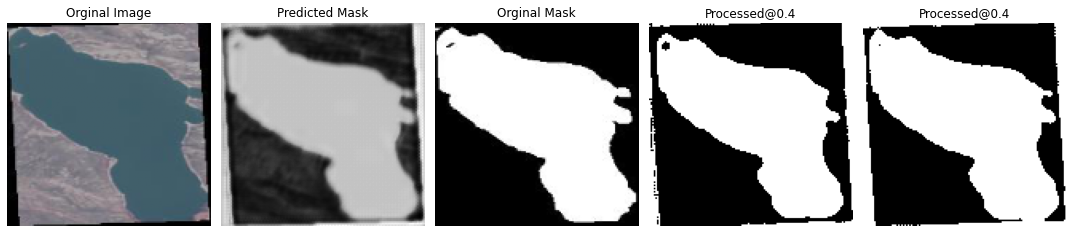

Epoch 2/100
72/72 [==============================] - 3s 47ms/step - loss: 0.5227 - accuracy: 0.6102 - val_loss: 0.4921 - val_accuracy: 0.5935


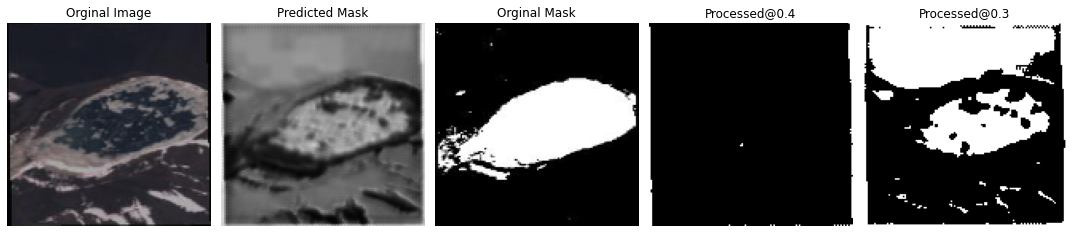

Epoch 3/100
72/72 [==============================] - 3s 47ms/step - loss: 0.4924 - accuracy: 0.6263 - val_loss: 0.4556 - val_accuracy: 0.6381


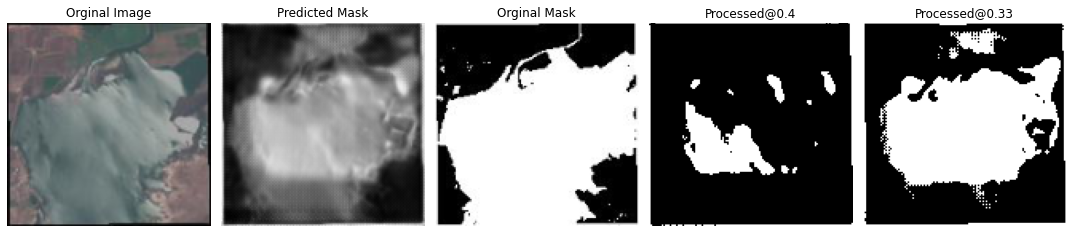

Epoch 4/100
72/72 [==============================] - 3s 48ms/step - loss: 0.4631 - accuracy: 0.6445 - val_loss: 0.4467 - val_accuracy: 0.6562


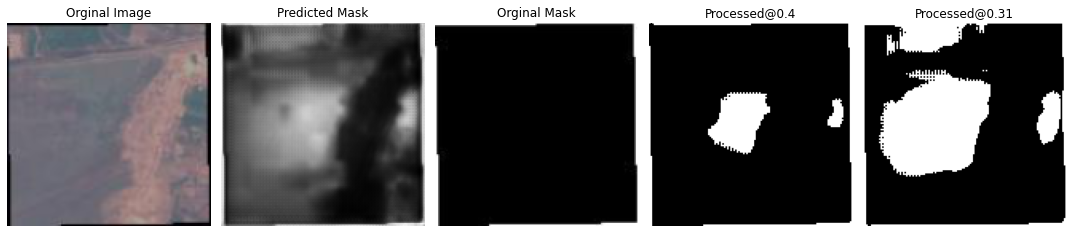

Epoch 5/100
72/72 [==============================] - 3s 48ms/step - loss: 0.4513 - accuracy: 0.6533 - val_loss: 0.4258 - val_accuracy: 0.6433


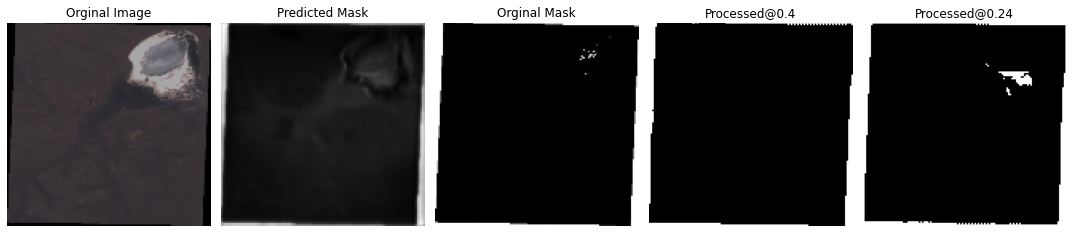

Epoch 6/100
72/72 [==============================] - 3s 48ms/step - loss: 0.4201 - accuracy: 0.6675 - val_loss: 0.4199 - val_accuracy: 0.6529


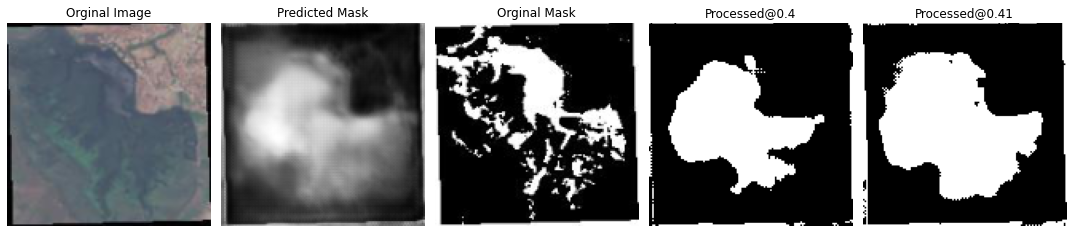

Epoch 7/100
72/72 [==============================] - 3s 48ms/step - loss: 0.3912 - accuracy: 0.6825 - val_loss: 0.4105 - val_accuracy: 0.6453


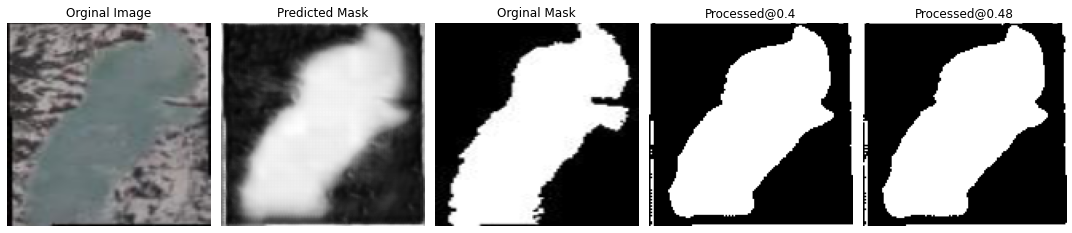

Epoch 8/100
72/72 [==============================] - 3s 48ms/step - loss: 0.3585 - accuracy: 0.6988 - val_loss: 0.3971 - val_accuracy: 0.6676


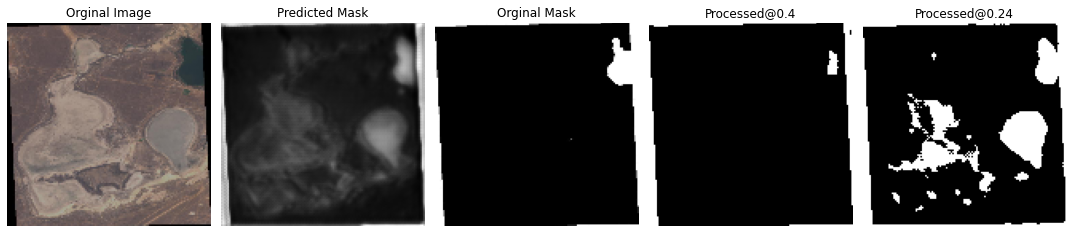

Epoch 9/100
72/72 [==============================] - 3s 48ms/step - loss: 0.3516 - accuracy: 0.7022 - val_loss: 0.3428 - val_accuracy: 0.6994


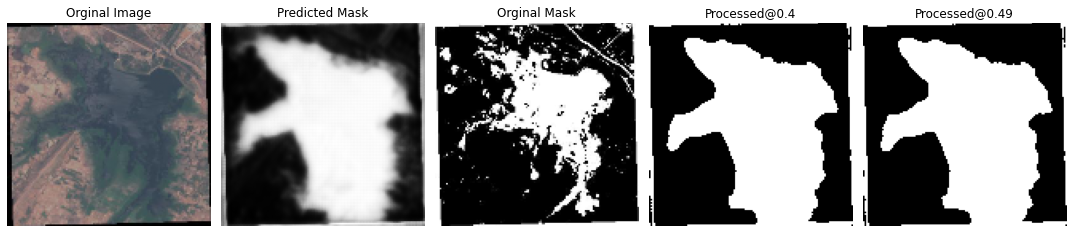

Epoch 10/100
72/72 [==============================] - 3s 47ms/step - loss: 0.3417 - accuracy: 0.7072 - val_loss: 0.3632 - val_accuracy: 0.6763


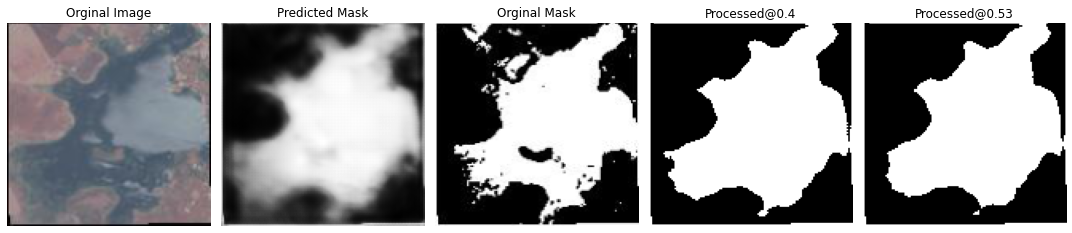

Epoch 11/100
72/72 [==============================] - 3s 47ms/step - loss: 0.3292 - accuracy: 0.7120 - val_loss: 0.3198 - val_accuracy: 0.7083


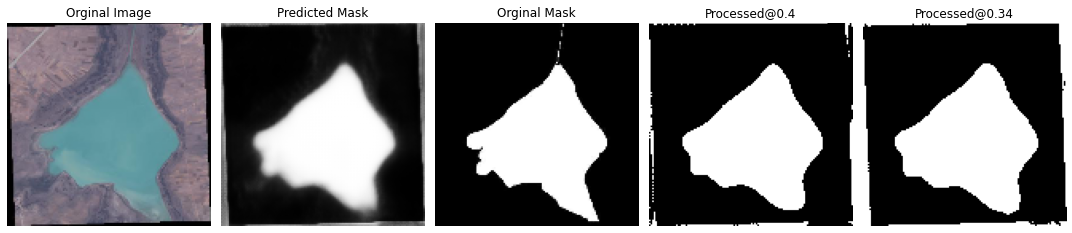

Epoch 12/100
72/72 [==============================] - 3s 47ms/step - loss: 0.3213 - accuracy: 0.7161 - val_loss: 0.4027 - val_accuracy: 0.6704


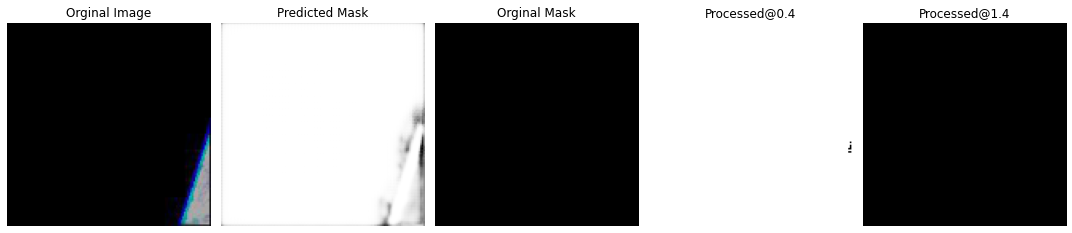

Epoch 13/100
72/72 [==============================] - 4s 49ms/step - loss: 0.3226 - accuracy: 0.7157 - val_loss: 0.2990 - val_accuracy: 0.7170


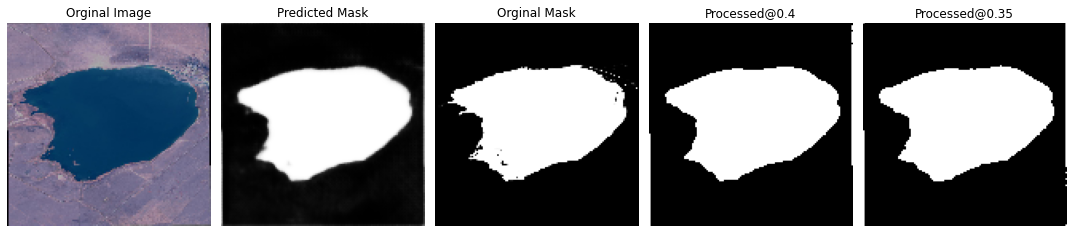

Epoch 14/100
72/72 [==============================] - 4s 51ms/step - loss: 0.3075 - accuracy: 0.7197 - val_loss: 0.2970 - val_accuracy: 0.7180


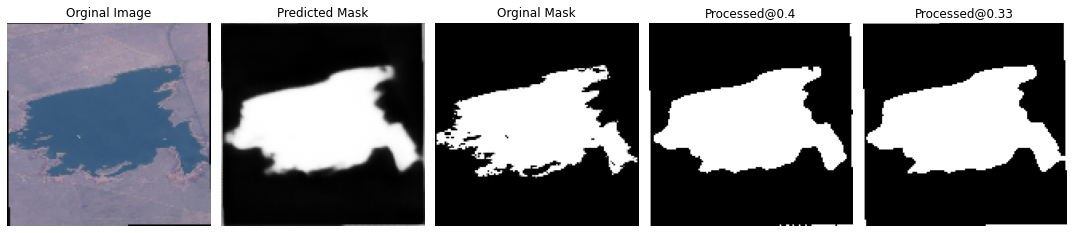

Epoch 15/100
72/72 [==============================] - 4s 50ms/step - loss: 0.3073 - accuracy: 0.7204 - val_loss: 0.3202 - val_accuracy: 0.7033


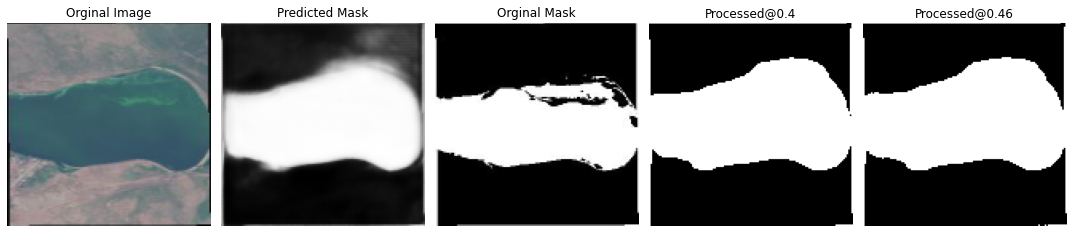

Epoch 16/100
72/72 [==============================] - 4s 51ms/step - loss: 0.3043 - accuracy: 0.7221 - val_loss: 0.2988 - val_accuracy: 0.7153


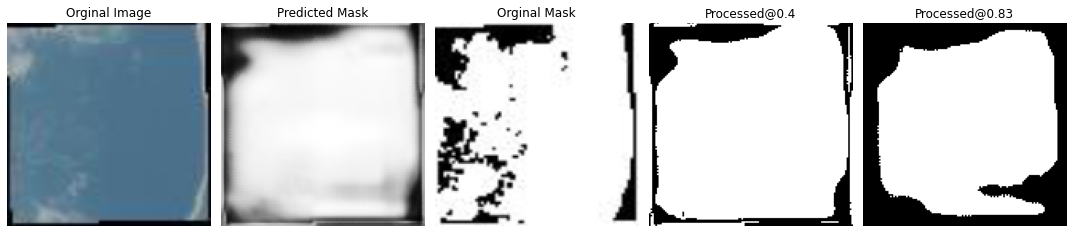

Epoch 17/100
72/72 [==============================] - 4s 49ms/step - loss: 0.2992 - accuracy: 0.7239 - val_loss: 0.2725 - val_accuracy: 0.7293


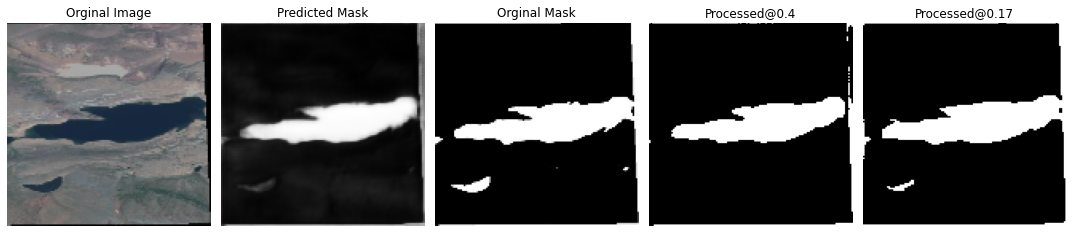

Epoch 18/100
72/72 [==============================] - 3s 48ms/step - loss: 0.2888 - accuracy: 0.7277 - val_loss: 0.3079 - val_accuracy: 0.7128


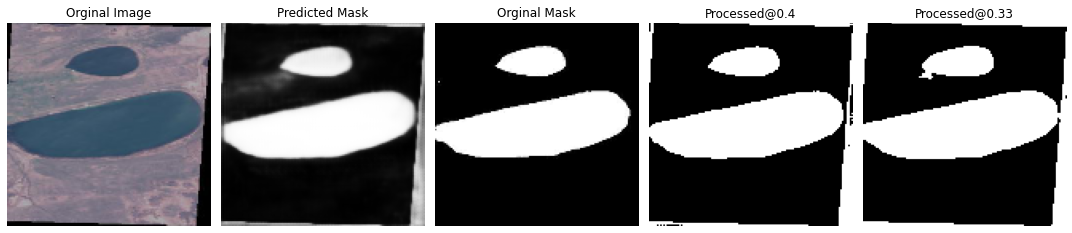

Epoch 19/100
72/72 [==============================] - 3s 48ms/step - loss: 0.2911 - accuracy: 0.7266 - val_loss: 0.2728 - val_accuracy: 0.7260


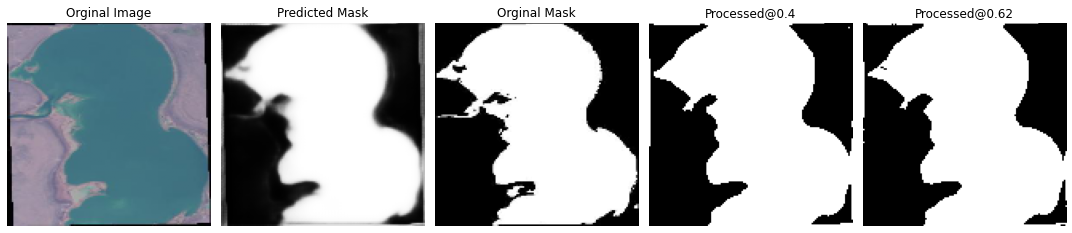

Epoch 20/100
72/72 [==============================] - 3s 47ms/step - loss: 0.2800 - accuracy: 0.7304 - val_loss: 0.2613 - val_accuracy: 0.7285


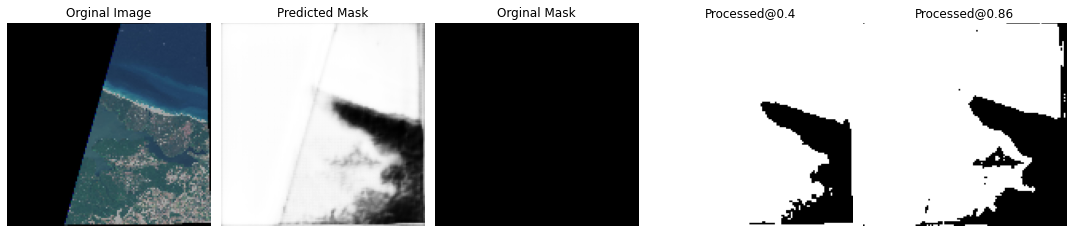

Epoch 21/100
72/72 [==============================] - 3s 49ms/step - loss: 0.2850 - accuracy: 0.7286 - val_loss: 0.2776 - val_accuracy: 0.7205


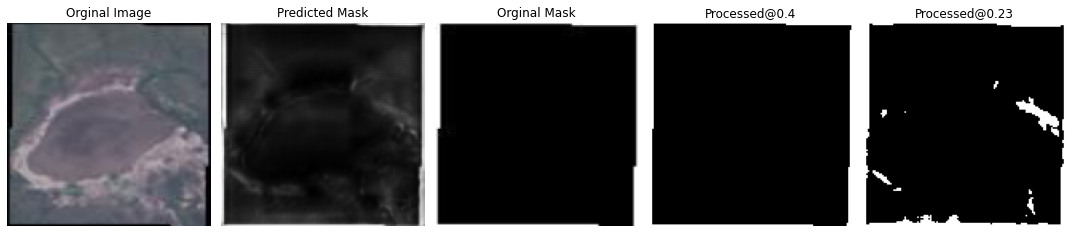

Epoch 22/100
72/72 [==============================] - 3s 48ms/step - loss: 0.2778 - accuracy: 0.7312 - val_loss: 0.2693 - val_accuracy: 0.7268


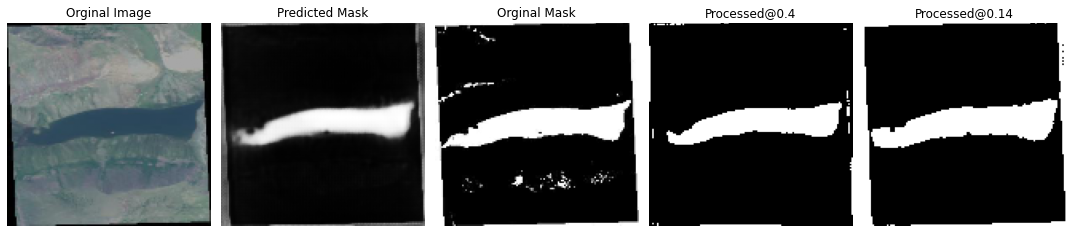

Epoch 23/100
72/72 [==============================] - 3s 48ms/step - loss: 0.2762 - accuracy: 0.7321 - val_loss: 0.2848 - val_accuracy: 0.7188


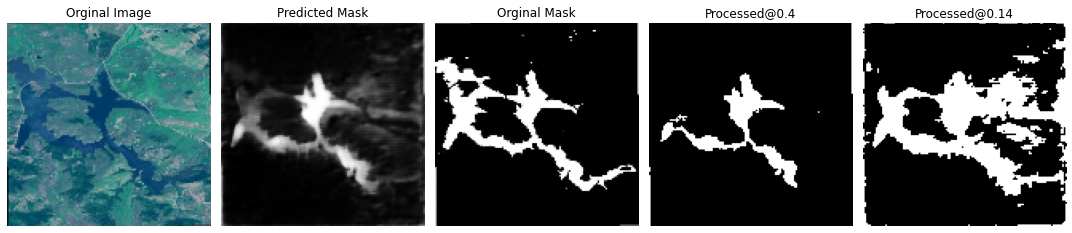

CPU times: user 1min 23s, sys: 4.87 s, total: 1min 28s
Wall time: 1min 37s


In [45]:
%%time
with tf.device("/GPU:0"):
  results = unet.fit(
      X, y,
      epochs=100,
      callbacks=callbacks,
      validation_split=0.1,
      batch_size=32
  )

You can decide what type of threshold you're willing to use. I kind of like loved the idea of using the adaptive threshold. Now, if you somehow find the best threshold value, then you can actually get the best masking, because the model is able to predict the mask correctly almost 99% of the time, but some of the regions are blurry and somehow, you will have to tackle them. My technique was to add this Adaptive Threshold your technique could be something else.

# **Testing**

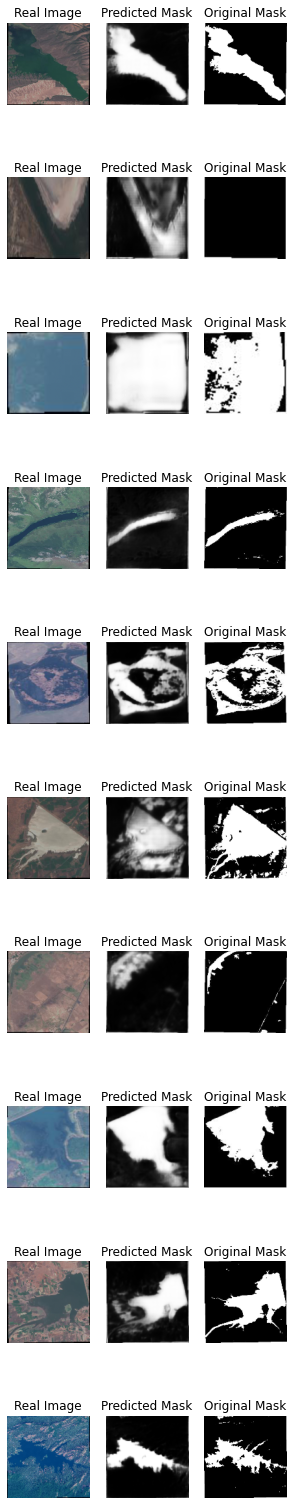

In [46]:
plt.figure(figsize=(5,28))
n=0
for i in range(1,31):
    plt.subplot(10,3,i)
    
    if n==0:
        id = np.random.randint(len(images))
        real_img = images[id][np.newaxis,...]
        pred_mask = unet.predict(real_img).reshape(128,128)
        mask = masks[id].reshape(128,128)
        show_image(real_img[0], title="Real Image")
        n+=1
    elif n==1:
        show_image(pred_mask, title="Predicted Mask", cmap='gray')
        n+=1
    elif n==2:
        show_image(mask, title="Original Mask", cmap='gray')
        n=0

The **high clarity** that you are able to find in the **original mask** is probably because they have used a **threshold** and that makes it **highly clear**. But as our model is **producing that image**, it's pretty good that it's able to **produce images with mask**, even if they are a **little bit of blurry**. 

---
Thanks!!! and if you have any suggestions, please let me know.

In [50]:
meanIoU = MeanIoU(num_classes=2)
for image, mask in zip(test_X, test_y):
    pred_mask = unet.predict(image[np.newaxis,...])
    meanIoU.update_state(mask, pred_mask)
print(meanIoU.result().numpy())

0.38314784


This **low meanIoU score** is because of the **high clarity** of the **original mask images**, where the **produced images** are **very blurry** and their **edges are not sharp**.